<a href="https://colab.research.google.com/github/yashveersinghsohi/Car_Price_Prediction/blob/master/EDA/CarPrice_01_Multivariate_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Data

The dataset was split into train-validation-test sets in the Univariate EDA notebook [here](https://github.com/yashveersinghsohi/Car_Price_Prediction/blob/master/EDA/CarPrice_00_Preliminary_EDA.ipynb)

The idea is to split the data into `train_val` set and `test` set in a 90-10 split. Subsequently, the `train_val` data is split into the `train` and the `val` sets according to a 80-20 split (of the `train-val` set and not the complete dataset).

In [2]:
root_dir = "https://raw.githubusercontent.com/yashveersinghsohi/Car_Price_Prediction/master/Data/EDA_Data/"

train_features_path = root_dir + "train_features.csv"
train_targets_path = root_dir + "train_targets.csv"

val_features_path = root_dir + "val_features.csv"
val_targets_path = root_dir + "val_targets.csv"

test_features_path = root_dir + "test_features.csv"
test_targets_path = root_dir + "test_targets.csv"

In [3]:
train_features = pd.read_csv(train_features_path)
train_targets = pd.read_csv(train_targets_path)

val_features = pd.read_csv(val_features_path)
val_targets = pd.read_csv(val_targets_path)

test_features = pd.read_csv(test_features_path)
test_targets = pd.read_csv(test_targets_path)

print(f"Train Features: {train_features.shape}")
print(f"Train Targets: {train_targets.shape}", end="\n\n")

print(f"Validation Features: {val_features.shape}")
print(f"Validation Targets: {val_targets.shape}", end="\n\n")

print(f"Test Features: {test_features.shape}")
print(f"Test Targets: {test_targets.shape}", end="\n\n")

Train Features: (13850, 16)
Train Targets: (13850, 1)

Validation Features: (3463, 16)
Validation Targets: (3463, 1)

Test Features: (1924, 16)
Test Targets: (1924, 1)



Columns with numeric and object data types.

In [4]:
num_features = ["Prod. year", "Cylinders", "Airbags"]
obj_features = ["Levy", "Manufacturer", "Model", 
                "Category", "Leather interior", 
                "Fuel type", "Engine volume", "Mileage", 
                "Gear box type", "Drive wheels", "Doors", 
                "Wheel", "Color"]
target_features = ["Price"]

# Multivariate EDA

## Numeric Features

In [5]:
num_features

['Prod. year', 'Cylinders', 'Airbags']

### Prod. year

Taking difference of `Prod. year` with the maximum value in the column to get a new feature useful for recording effects of depreciation.

In [64]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Prod. year"].to_numpy(),
          train_targets["Price"].to_numpy()
        ], 
    columns=["Prod. year", "Price"]
  )

temp_df["Time Difference"] = (temp_df["Prod. year"] - temp_df["Prod. year"].max()).abs()

temp_df.head()

,Prod. year,Price,Time Difference
0,2014,21953,6
1,1998,8154,22
2,2010,8674,10
3,1997,7840,23
4,2016,53154,4


The features are not at all correlated with `Price`. This is opposite to what intuition dictates.

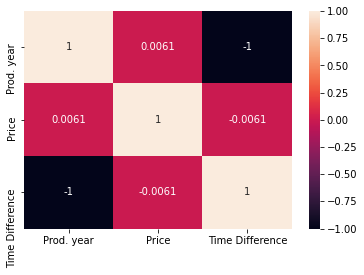

In [65]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(temp_df.corr(), annot=True, ax=ax)
plt.show()

Scatter Plot of `Time Difference` with `Price`, but for only those cars with `Price < 100,100`

Number of cars with price less than 100,000: 13763
Total number of cars: 13850


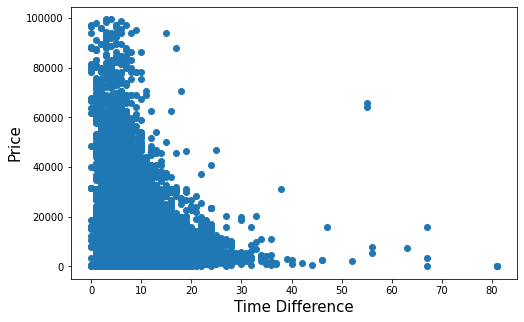

In [66]:
ids = temp_df[temp_df["Price"]<=1e5].index
print(f"Number of cars with price less than 100,000: {len(ids)}\nTotal number of cars: {len(temp_df.index)}")

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(temp_df.loc[ids, "Time Difference"], temp_df.loc[ids, "Price"])
ax.set_xlabel("Time Difference", size=15)
ax.set_ylabel("Price", size=15)
plt.show()

There is a clear relationship, but it is not linear.

Lets try to segment the data based on new/old cars

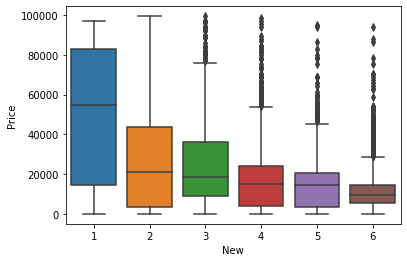

In [82]:
temp_df["New"] = np.where(temp_df["Time Difference"]<1, 1, 0)
temp_df["New"] = np.where((temp_df["Time Difference"]<4) & (temp_df["Time Difference"]>=1), 2, temp_df["New"])
temp_df["New"] = np.where((temp_df["Time Difference"]<6) & (temp_df["Time Difference"]>=4), 3, temp_df["New"])
temp_df["New"] = np.where((temp_df["Time Difference"]<8) & (temp_df["Time Difference"]>=6), 4, temp_df["New"])
temp_df["New"] = np.where((temp_df["Time Difference"]<10) & (temp_df["Time Difference"]>=8), 5, temp_df["New"])
temp_df["New"] = np.where(temp_df["Time Difference"]>=10, 6, temp_df["New"])

ids = temp_df[temp_df["Price"]<1e5].index
sns.boxplot(data=temp_df.loc[ids, :], x="New", y="Price")
plt.show()

In [83]:
temp_df.groupby(by="New").count()

,Prod. year,Price,Time Difference
New,,,
1,37,37,37
2,1240,1240,1240
3,2193,2193,2193
4,2962,2962,2962
5,2704,2704,2704
6,4714,4714,4714


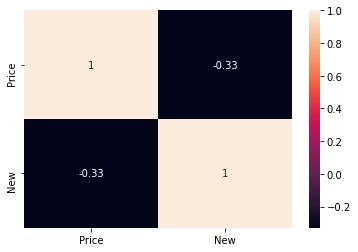

In [84]:
ids = temp_df[temp_df["Price"]<1e5].index
sns.heatmap(data=temp_df.loc[ids, ["Price", "New"]].corr(), annot=True)
plt.show()

### Cylinders

Collecting `Cylinders` and `Price` columns

In [10]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Cylinders"].to_numpy(),
          train_targets["Price"].to_numpy()
        ], 
    columns=["Cylinders", "Price"]
  )
temp_df.head()

,Cylinders,Price
0,4.0,21953.0
1,6.0,8154.0
2,4.0,8674.0
3,4.0,7840.0
4,4.0,53154.0


Plotting heatmap with and without outlier removal

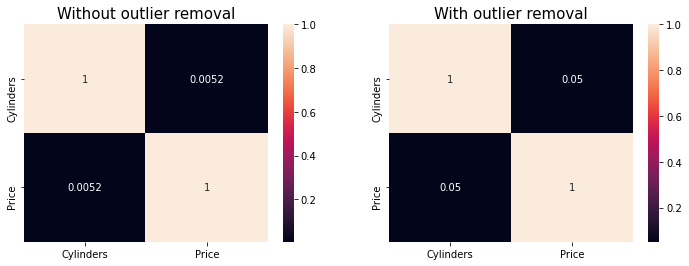

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(temp_df.corr(), annot=True, ax=ax[0])
ax[0].set_title("Without outlier removal", size=15)

ids = temp_df[temp_df["Price"]<=1e5].index
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True, ax=ax[1])
ax[1].set_title("With outlier removal", size=15)
plt.show()

Plotting scatter plot with outlier removal

Number of cars with price less than 100,000: 13763
Total number of cars: 13850


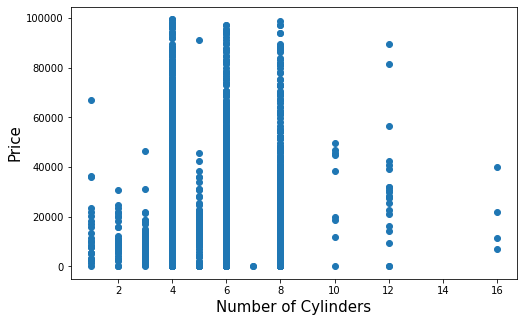

In [12]:
ids = temp_df[temp_df["Price"]<=1e5].index
print(f"Number of cars with price less than 100,000: {len(ids)}\nTotal number of cars: {len(temp_df.index)}")

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(temp_df.loc[ids, "Cylinders"], temp_df.loc[ids, "Price"])

ax.set_xlabel("Number of Cylinders", size=15)
ax.set_ylabel("Price", size=15)

plt.show()

No direct relation with `Price`.

### Airbags

Collecting `Airbags` and `Price` columns

In [13]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Airbags"].to_numpy(),
          train_targets["Price"].to_numpy()
        ], 
    columns=["Airbags", "Price"]
  )
temp_df.head()

,Airbags,Price
0,8,21953
1,6,8154
2,4,8674
3,4,7840
4,4,53154


Heatmaps with and without outlier removal

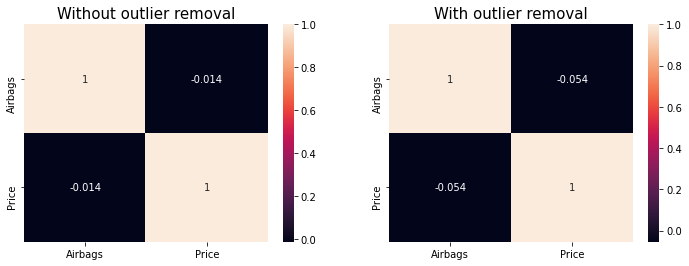

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(temp_df.corr(), annot=True, ax=ax[0])
ax[0].set_title("Without outlier removal", size=15)

ids = temp_df[temp_df["Price"]<=1e5].index
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True, ax=ax[1])
ax[1].set_title("With outlier removal", size=15)
plt.show()

Scatter Plot with outlier removal

Number of cars with price less than 100,000: 13763
Total number of cars: 13850


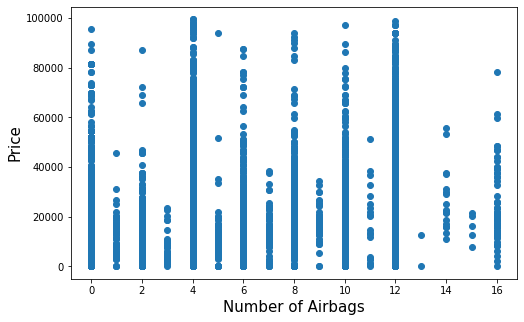

In [15]:
ids = temp_df[temp_df["Price"]<=1e5].index
print(f"Number of cars with price less than 100,000: {len(ids)}\nTotal number of cars: {len(temp_df.index)}")

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(temp_df.loc[ids, "Airbags"], temp_df.loc[ids, "Price"])

ax.set_xlabel("Number of Airbags", size=15)
ax.set_ylabel("Price", size=15)

plt.show()

## Object Features

### Levy

Collecting `Levy` and `Price`

In [16]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Levy"].replace(to_replace="-", value="0"),
          train_features["Levy"].replace(to_replace="-", value=np.nan),
          train_targets["Price"].to_numpy()
        ], 
    columns=["Levy", "Levy NaNs", "Price"], dtype=np.float
  )
temp_df.head()

,Levy,Levy NaNs,Price
0,308.0,308.0,21953.0
1,0.0,NaN,8154.0
2,687.0,687.0,8674.0
3,0.0,NaN,7840.0
4,891.0,891.0,53154.0


Heatmaps with and without outlier removal (from `Price`), and with or without Null value removal from `Levy`

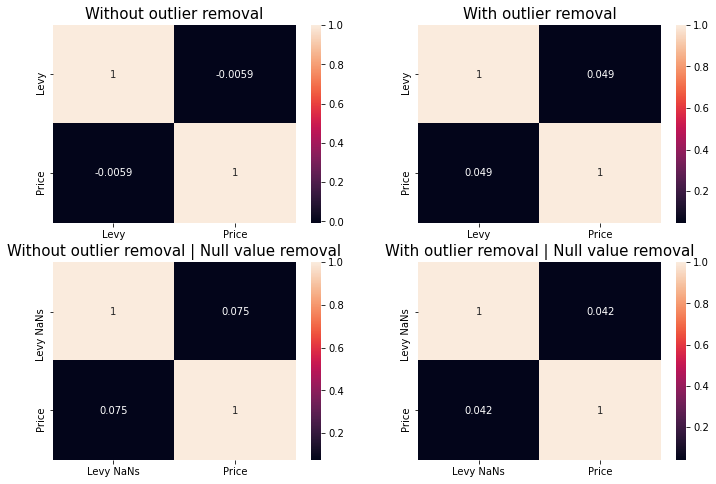

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

sns.heatmap(temp_df[["Levy", "Price"]].corr(), annot=True, ax=ax[0, 0])
ax[0, 0].set_title("Without outlier removal", size=15)

ids = temp_df[temp_df["Price"]<=1e5].index
sns.heatmap(temp_df.loc[ids, ["Levy", "Price"]].corr(), annot=True, ax=ax[0, 1])
ax[0, 1].set_title("With outlier removal", size=15)

sns.heatmap(temp_df[["Levy NaNs", "Price"]].dropna().corr(), annot=True, ax=ax[1, 0])
ax[1, 0].set_title("Without outlier removal | Null value removal", size=15)

ids = temp_df[temp_df["Price"]<=1e5].index
sns.heatmap(temp_df.loc[ids, ["Levy NaNs", "Price"]].dropna().corr(), annot=True, ax=ax[1, 1])
ax[1, 1].set_title("With outlier removal | Null value removal", size=15)

plt.show()

Number of cars with price less than 100,000: 13763
Total number of cars: 13850


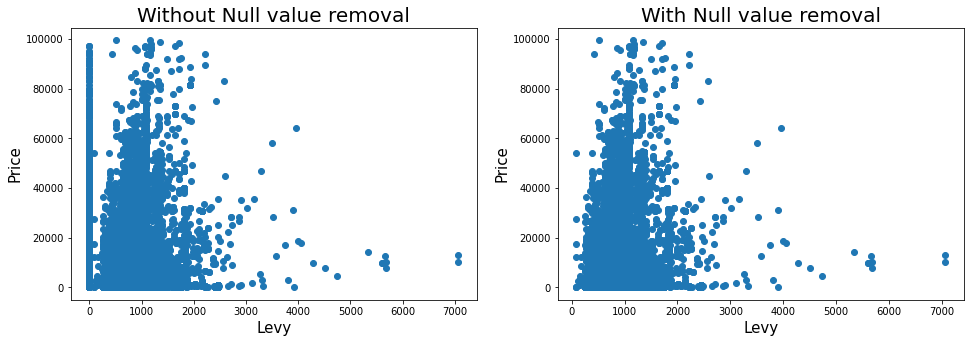

In [18]:
ids = temp_df[temp_df["Price"]<=1e5].index
print(f"Number of cars with price less than 100,000: {len(ids)}\nTotal number of cars: {len(temp_df.index)}")

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].scatter(temp_df.loc[ids, "Levy"], temp_df.loc[ids, "Price"])
ax[1].scatter(temp_df.loc[ids, ["Levy NaNs", "Price"]].dropna()["Levy NaNs"], 
              temp_df.loc[ids, ["Levy NaNs", "Price"]].dropna()["Price"])

ax[0].set_xlabel("Levy", size=15)
ax[0].set_ylabel("Price", size=15)
ax[0].set_title("Without Null value removal", size=20)

ax[1].set_xlabel("Levy", size=15)
ax[1].set_ylabel("Price", size=15)
ax[1].set_title("With Null value removal", size=20)

plt.show()

Removal of Outliers from `Levy` too, and then carrying out the same analysis

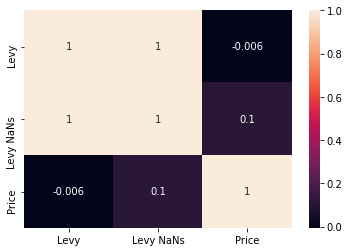

In [19]:
without_outlier = temp_df[temp_df["Levy"]<2000]
sns.heatmap(without_outlier.corr(), annot=True)
plt.show()

Removing outliers from `Levy` helped, but not a lot.

Trying to use standard scaler with `Levy`

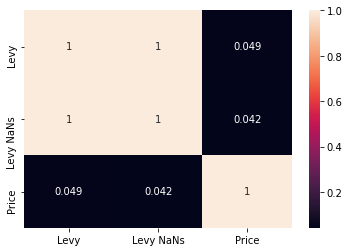

In [20]:
scaled_df = temp_df.copy()

ids = scaled_df[scaled_df["Price"]<=1e5].index

scaler = StandardScaler()
scaled_df["Levy"] = scaler.fit_transform(temp_df[["Levy"]])
scaled_df["Levy NaNs"] = scaler.fit_transform(temp_df[["Levy NaNs"]])

sns.heatmap(scaled_df.loc[ids, :].corr(), annot=True)
plt.show()

### Manufacturer

Collecting `Manufacturer` and `Price` columns

In [21]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Manufacturer"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Manufacturer", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df.head()

,Manufacturer,Price
0,LEXUS,21953
1,MERCEDES-BENZ,8154
2,DAEWOO,8674
3,MERCEDES-BENZ,7840
4,HYUNDAI,53154


Boxplots for `Price` of each `Manufacturer`

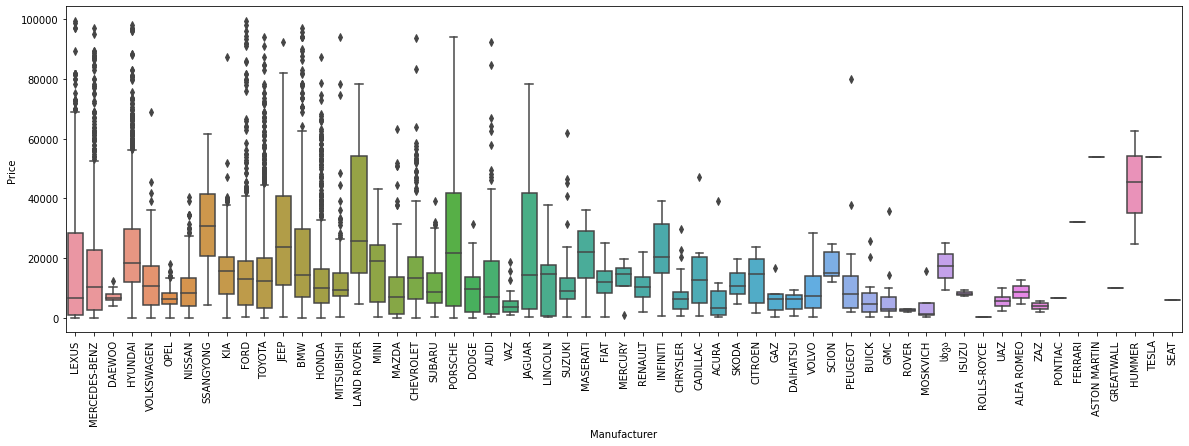

In [22]:
ids = temp_df[temp_df["Price"]<1e5].index

fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(data=temp_df.loc[ids, :], x="Manufacturer", y="Price", ax=ax)
ax.tick_params('x', labelrotation=90)
plt.show()

Median `Price` for each `Manufacturer`

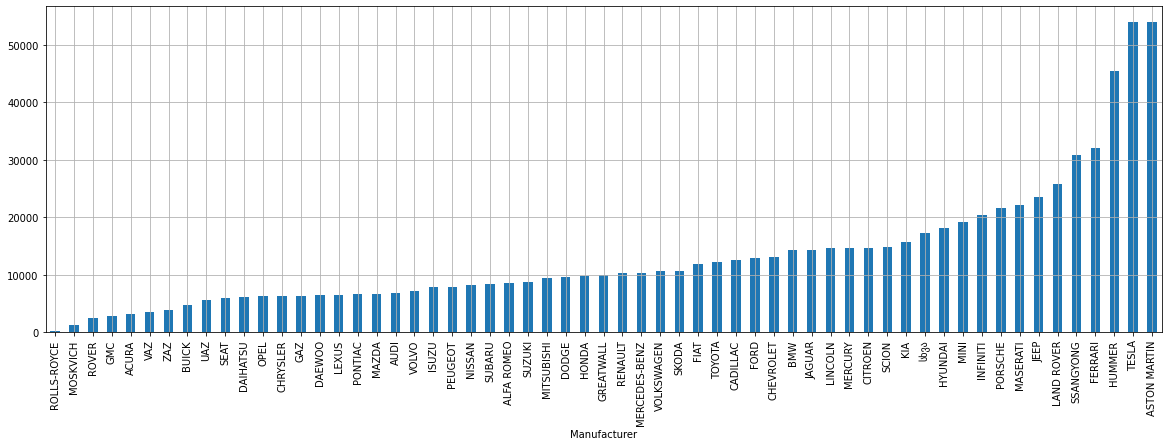

In [23]:
ids = temp_df[temp_df["Price"]<1e5].index
sorted_by_median = temp_df.loc[ids, :].groupby(by="Manufacturer")["Price"].median().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(20, 6))
sorted_by_median.plot.bar(ax=ax)
ax.grid()
plt.show()

Ordering `Manufacturer`s by their median `Price`

In [24]:
sorted_by_median.index

Index(['ROLLS-ROYCE', 'MOSKVICH', 'ROVER', 'GMC', 'ACURA', 'VAZ', 'ZAZ',
       'BUICK', 'UAZ', 'SEAT', 'DAIHATSU', 'OPEL', 'CHRYSLER', 'GAZ', 'DAEWOO',
       'LEXUS', 'PONTIAC', 'MAZDA', 'AUDI', 'VOLVO', 'ISUZU', 'PEUGEOT',
       'NISSAN', 'SUBARU', 'ALFA ROMEO', 'SUZUKI', 'MITSUBISHI', 'DODGE',
       'HONDA', 'GREATWALL', 'RENAULT', 'MERCEDES-BENZ', 'VOLKSWAGEN', 'SKODA',
       'FIAT', 'TOYOTA', 'CADILLAC', 'FORD', 'CHEVROLET', 'BMW', 'JAGUAR',
       'LINCOLN', 'MERCURY', 'CITROEN', 'SCION', 'KIA', 'სხვა', 'HYUNDAI',
       'MINI', 'INFINITI', 'PORSCHE', 'MASERATI', 'JEEP', 'LAND ROVER',
       'SSANGYONG', 'FERRARI', 'HUMMER', 'TESLA', 'ASTON MARTIN'],
      dtype='object', name='Manufacturer')

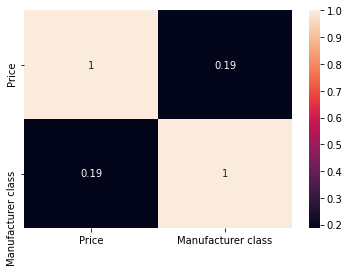

In [25]:
class_1 = ['ROLLS-ROYCE', 'MOSKVICH', 'ROVER', 'GMC', 'ACURA', 'VAZ', 'ZAZ', 
           'BUICK', 'UAZ', 'SEAT', 'DAIHATSU', 'OPEL', 'CHRYSLER', 'GAZ', 
           'DAEWOO', 'LEXUS', 'PONTIAC', 'MAZDA', 'AUDI', 'VOLVO', 'ISUZU', 
           'PEUGEOT', 'NISSAN', 'SUBARU', 'ALFA ROMEO', 'SUZUKI', 'MITSUBISHI', 
           'DODGE', 'HONDA', 'GREATWALL']
class_2 = ['RENAULT', 'MERCEDES-BENZ', 'VOLKSWAGEN', 'SKODA', 
           'FIAT', 'TOYOTA', 'CADILLAC', 'FORD', 'CHEVROLET', 'BMW', 'JAGUAR',
           'LINCOLN', 'MERCURY', 'CITROEN', 'SCION', 'KIA', 'სხვა', 'HYUNDAI',
           'MINI', 'INFINITI']
class_3 = ['PORSCHE', 'MASERATI', 'JEEP', 'LAND ROVER', 'SSANGYONG', 'FERRARI']
class_4 = ['HUMMER', 'TESLA', 'ASTON MARTIN']


temp_df["Manufacturer class"] = np.where(temp_df["Manufacturer"].isin(class_1), 1, 0)
temp_df["Manufacturer class"] = np.where(temp_df["Manufacturer"].isin(class_2), 2, temp_df["Manufacturer class"])
temp_df["Manufacturer class"] = np.where(temp_df["Manufacturer"].isin(class_3), 3, temp_df["Manufacturer class"])
temp_df["Manufacturer class"] = np.where(temp_df["Manufacturer"].isin(class_4), 4, temp_df["Manufacturer class"])

ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True)
plt.show()

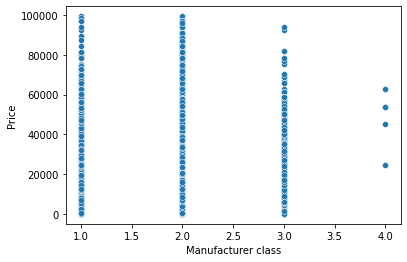

In [26]:
ids = temp_df[temp_df["Price"]<1e5].index
sns.scatterplot(data=temp_df.loc[ids, :], x="Manufacturer class", y="Price")
plt.show()

This kind of ordering has very low linear correlation with correlation `Price`

Ordering w.r.t the most common `Manufacturer`s

In [27]:
sorted_by_median.index.sort_values()

Index(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BMW', 'BUICK',
       'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO', 'DAIHATSU',
       'DODGE', 'FERRARI', 'FIAT', 'FORD', 'GAZ', 'GMC', 'GREATWALL', 'HONDA',
       'HUMMER', 'HYUNDAI', 'INFINITI', 'ISUZU', 'JAGUAR', 'JEEP', 'KIA',
       'LAND ROVER', 'LEXUS', 'LINCOLN', 'MASERATI', 'MAZDA', 'MERCEDES-BENZ',
       'MERCURY', 'MINI', 'MITSUBISHI', 'MOSKVICH', 'NISSAN', 'OPEL',
       'PEUGEOT', 'PONTIAC', 'PORSCHE', 'RENAULT', 'ROLLS-ROYCE', 'ROVER',
       'SCION', 'SEAT', 'SKODA', 'SSANGYONG', 'SUBARU', 'SUZUKI', 'TESLA',
       'TOYOTA', 'UAZ', 'VAZ', 'VOLKSWAGEN', 'VOLVO', 'ZAZ', 'სხვა'],
      dtype='object', name='Manufacturer')

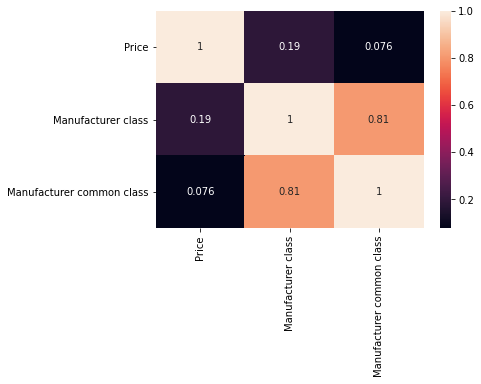

In [28]:
common_class_1 = ["NISSAN", "VOLKSWAGEN", "SSANGYONG", "KIA", "OPEL", 
                  "MITSUBISHI", "SABARU", "MAZDA", "JEEP"]
common_class_2 = ["LEXUX", "HONDA", "BMW", "FORD", "CHEVROLET"]
common_class_3 = ["MERCEDES-BENZ", "TOYOTA", "HUNDAI"]


temp_df["Manufacturer common class"] = np.where(temp_df["Manufacturer"].isin(common_class_1), 1, 0)
temp_df["Manufacturer common class"] = np.where(temp_df["Manufacturer"].isin(common_class_2), 2, temp_df["Manufacturer class"])
temp_df["Manufacturer common class"] = np.where(temp_df["Manufacturer"].isin(common_class_3), 3, temp_df["Manufacturer class"])

ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True)
plt.show()

Again, the relationship is not very common

### Model

Too many distinct categories for it to capture any meaningful trend

### Category

Collecting `Category` and `Price` columns

In [29]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Category"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Category", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df.head()

,Category,Price
0,Hatchback,21953
1,Sedan,8154
2,Sedan,8674
3,Sedan,7840
4,Jeep,53154


Boxplots for each type of `Category`

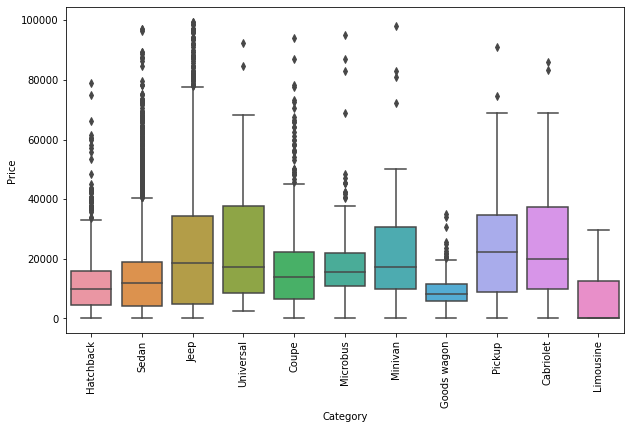

In [30]:
ids = temp_df[temp_df["Price"]<1e5].index

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=temp_df.loc[ids, :], x="Category", y="Price", ax=ax)
ax.tick_params('x', labelrotation=90)
plt.show()

Ordering `Category` by common types

In [31]:
temp_df["Category"].unique()

array(['Hatchback', 'Sedan', 'Jeep', 'Universal', 'Coupe', 'Microbus',
       'Minivan', 'Goods wagon', 'Pickup', 'Cabriolet', 'Limousine'],
      dtype=object)

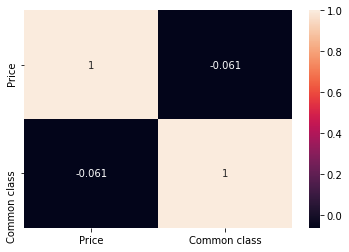

In [32]:
common_class_1 = ["Hatchback"]
common_class_2 = ["Jeep"]
common_class_3 = ["Sedan"]

temp_df["Common class"] = np.where(temp_df["Category"].isin(common_class_1), 1, 0)
temp_df["Common class"] = np.where(temp_df["Category"].isin(common_class_2), 2, temp_df["Common class"])
temp_df["Common class"] = np.where(temp_df["Category"].isin(common_class_3), 3, temp_df["Common class"])

ids = temp_df[temp_df["Price"]<1e5].index

fig, ax = plt.subplots()
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True)
plt.show()

Ordering `Category` by mean and median `Price`

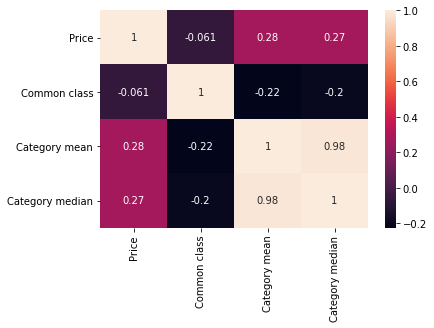

In [33]:
ids = temp_df[temp_df["Price"]<1e5].index
temp_subset = temp_df.loc[ids, :]

mean_ordering = temp_subset.groupby(by="Category")["Price"].mean().sort_values(ascending=True)
mean_map = {category: category_idx for category_idx, category in enumerate(mean_ordering.index)}
temp_df["Category mean"] = temp_df["Category"].map(mean_map)

median_ordering = temp_subset.groupby(by="Category")["Price"].median().sort_values(ascending=True)
median_map = {category: category_idx for category_idx, category in enumerate(median_ordering.index)}
temp_df["Category median"] = temp_df["Category"].map(median_map)

fig, ax = plt.subplots()
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True)
plt.show()

Some linear relationship with mean/median `Price` ordering

### Leather interior

Collecting `Leather interior` and `Price` columns

In [34]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Leather interior"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Leather interior", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df.head()

,Leather interior,Price
0,Yes,21953
1,Yes,8154
2,Yes,8674
3,No,7840
4,Yes,53154


Boxplots for different category of `Leather interior`

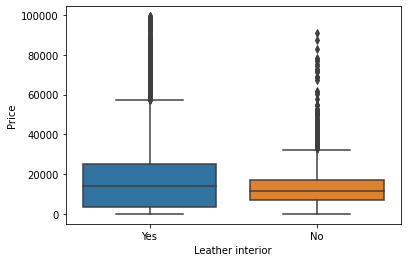

In [35]:
fig, ax = plt.subplots()
ids = temp_df[temp_df["Price"]<1e5].index
sns.boxplot(data=temp_df.loc[ids, :], x="Leather interior", y="Price", ax=ax)
plt.show()

Heatmap

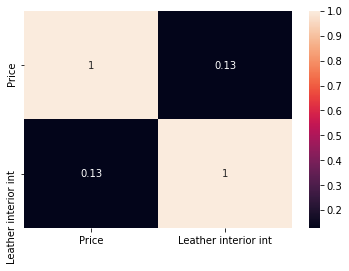

In [36]:
temp_df["Leather interior int"] = temp_df["Leather interior"].map({"Yes": 1, "No": 0})

fig, ax = plt.subplots()
ids = temp_df[temp_df["Price"]<1e5].index
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True, ax=ax)
plt.show()

Cars with `Leather interior` are a bit more expensive.

### Fuel type

Collecting `Fuel type` and `Price` columns

In [37]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Fuel type"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Fuel type", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df.head()

,Fuel type,Price
0,Hybrid,21953
1,CNG,8154
2,Petrol,8674
3,Petrol,7840
4,Diesel,53154


Boxplot for each category of `Fuel type`

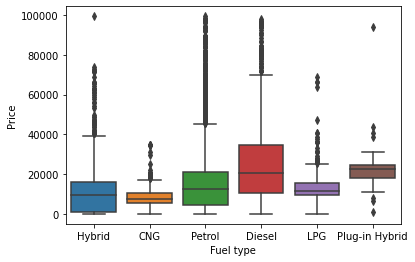

In [38]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.boxplot(data=temp_df.loc[ids, :], x="Fuel type", y="Price", ax=ax)
plt.show()

Heatmap for mean and median `Price` ordering

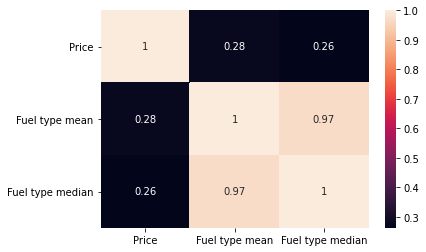

In [39]:
ids = temp_df[temp_df["Price"]<1e5].index
temp_subset = temp_df.loc[ids, :]

mean_ordering = temp_subset.groupby(by="Fuel type")["Price"].mean().sort_values(ascending=True)
mean_map = {fuel: fuel_idx for fuel_idx, fuel in enumerate(mean_ordering.index)}
temp_df["Fuel type mean"] = temp_df["Fuel type"].map(mean_map)

median_ordering = temp_subset.groupby(by="Fuel type")["Price"].median().sort_values(ascending=True)
median_map = {fuel: fuel_idx for fuel_idx, fuel in enumerate(median_ordering.index)}
temp_df["Fuel type median"] = temp_df["Fuel type"].map(median_map)

fig, ax = plt.subplots()
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True)
plt.show()

### Engine volume

Collecting `Engine volume`, `Price`, converting `Engine volume` to float and adding `Turbo` binary variable.

In [40]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Engine volume"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Engine volume", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df["Turbo"] = np.where(temp_df["Engine volume"].str.contains("Turbo"), 1, 0)
temp_df["Engine volume num"] = temp_df["Engine volume"].str.replace(" Turbo", "").astype(np.float)
temp_df.head()

,Engine volume,Price,Turbo,Engine volume num
0,1.8,21953,0,1.8
1,3.2,8154,0,3.2
2,1.6,8674,0,1.6
3,2,7840,0,2.0
4,2,53154,0,2.0


Boxplot for different types of `Turbo`

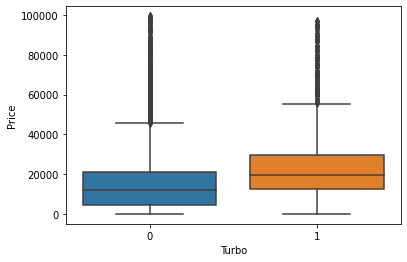

In [41]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.boxplot(data=temp_df.loc[ids, :], x="Turbo", y="Price", ax=ax)
plt.show()

Heatmap

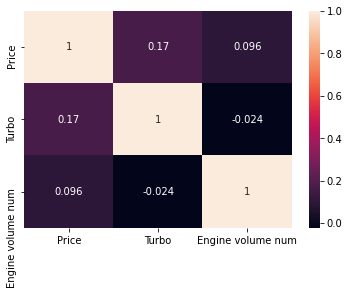

In [42]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.heatmap(data=temp_df.loc[ids, :].corr(), annot=True, ax=ax)
plt.show()

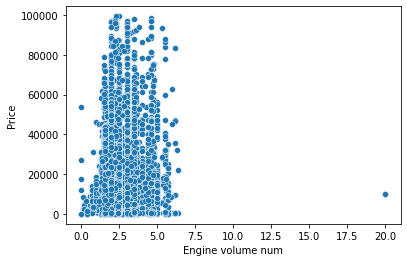

In [43]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.scatterplot(data=temp_df.loc[ids, :], x="Engine volume num", y="Price", ax=ax)
plt.show()

`Turbo` cars are a bit more expensive. Engine volume does not seem to have much linear relation with `Price`. There seem to be outliers in `Engine volume`.

### Mileage

Collecting `Mileage`, `Price`, converting `Mileage` to float and adding `New` binary variable (denoting `Mileage=0`).

In [44]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Mileage"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Mileage", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df["Mileage num"] = temp_df["Mileage"].str.replace(" km", "").astype(np.float)
temp_df["New"] = np.where(temp_df["Mileage num"] == 0, 1, 0)
temp_df.head()

,Mileage,Price,Mileage num,New
0,192000 km,21953,192000.0,0
1,220000 km,8154,220000.0,0
2,140000 km,8674,140000.0,0
3,305125 km,7840,305125.0,0
4,102313 km,53154,102313.0,0


Boxplot for `New`

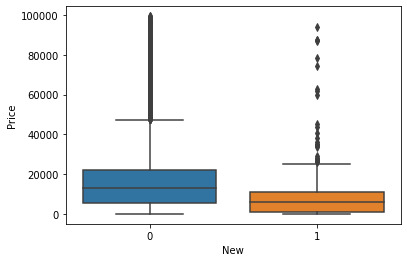

In [45]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.boxplot(data=temp_df.loc[ids, :], x="New", y="Price", ax=ax)
plt.show()

Heatmap

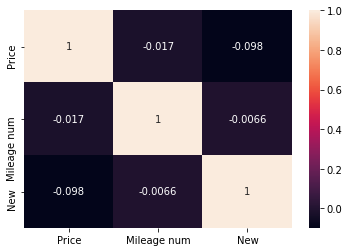

In [46]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.heatmap(data=temp_df.loc[ids, :].corr(), annot=True, ax=ax)
plt.show()

Scatter plot

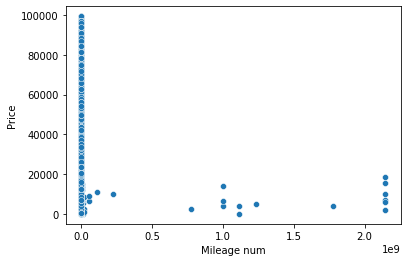

In [47]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.scatterplot(data=temp_df.loc[ids, :], x="Mileage num", y="Price", ax=ax)
plt.show()

New cars are not more expensive. No obvious trend here.

### Gear box type

Collecting `Gear box type` and `Price`

In [48]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Gear box type"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Gear box type", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df.head()

,Gear box type,Price
0,Variator,21953
1,Tiptronic,8154
2,Automatic,8674
3,Manual,7840
4,Automatic,53154


Boxplots

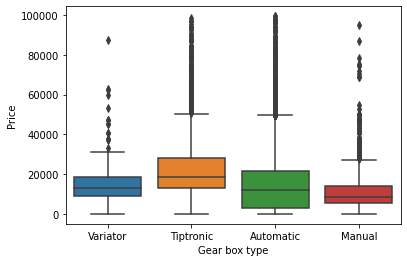

In [49]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.boxplot(data=temp_df.loc[ids, :], x="Gear box type", y="Price", ax=ax)
plt.show()

Heatmap

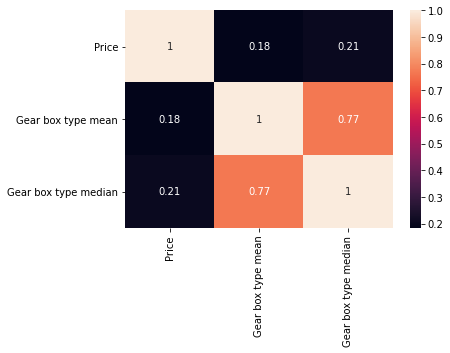

In [50]:
ids = temp_df[temp_df["Price"]<1e5].index
temp_subset = temp_df.loc[ids, :]

mean_ordering = temp_subset.groupby(by="Gear box type")["Price"].mean().sort_values(ascending=True)
mean_map = {gear: gear_idx for gear_idx, gear in enumerate(mean_ordering.index)}
temp_df["Gear box type mean"] = temp_df["Gear box type"].map(mean_map)

median_ordering = temp_subset.groupby(by="Gear box type")["Price"].median().sort_values(ascending=True)
median_map = {gear: gear_idx for gear_idx, gear in enumerate(median_ordering.index)}
temp_df["Gear box type median"] = temp_df["Gear box type"].map(median_map)

fig, ax = plt.subplots()
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True)
plt.show()

Not a strong linear relation with `Price`

### Drive wheels

Collecting columns

In [51]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Drive wheels"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Drive wheels", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df.head()

,Drive wheels,Price
0,Front,21953
1,Rear,8154
2,Front,8674
3,Rear,7840
4,Front,53154


Boxplots

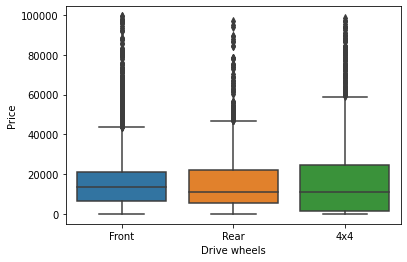

In [52]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.boxplot(data=temp_df.loc[ids, :], x="Drive wheels", y="Price", ax=ax)
plt.show()

Heatmaps

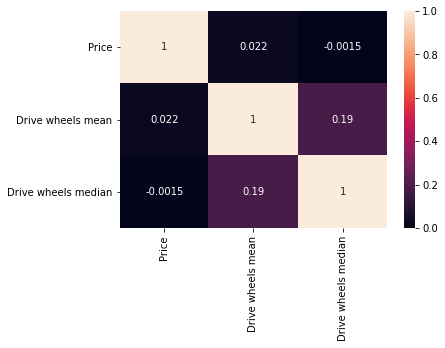

In [53]:
ids = temp_df[temp_df["Price"]<1e5].index
temp_subset = temp_df.loc[ids, :]

mean_ordering = temp_subset.groupby(by="Drive wheels")["Price"].mean().sort_values(ascending=True)
mean_map = {drive: drive_idx for drive_idx, drive in enumerate(mean_ordering.index)}
temp_df["Drive wheels mean"] = temp_df["Drive wheels"].map(mean_map)

median_ordering = temp_subset.groupby(by="Drive wheels")["Price"].median().sort_values(ascending=True)
median_map = {drive: drive_idx for drive_idx, drive in enumerate(median_ordering.index)}
temp_df["Drive wheels median"] = temp_df["Drive wheels"].map(median_map)

fig, ax = plt.subplots()
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True)
plt.show()

All 3 types are roughly the same in terms of `Price`

### Doors

Collecting columns

In [54]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Doors"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Doors", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df.head()

,Doors,Price
0,04-May,21953
1,04-May,8154
2,04-May,8674
3,04-May,7840
4,04-May,53154


Boxplots

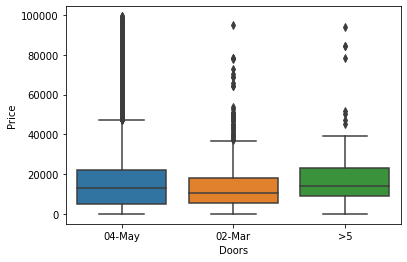

In [55]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.boxplot(data=temp_df.loc[ids, :], x="Doors", y="Price", ax=ax)
plt.show()

Heatmap

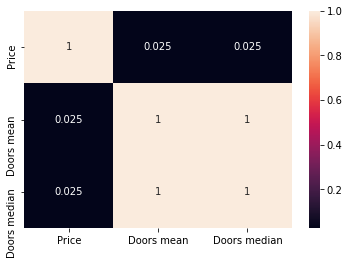

In [56]:
ids = temp_df[temp_df["Price"]<1e5].index
temp_subset = temp_df.loc[ids, :]

mean_ordering = temp_subset.groupby(by="Doors")["Price"].mean().sort_values(ascending=True)
mean_map = {door: door_idx for door_idx, door in enumerate(mean_ordering.index)}
temp_df["Doors mean"] = temp_df["Doors"].map(mean_map)

median_ordering = temp_subset.groupby(by="Doors")["Price"].median().sort_values(ascending=True)
median_map = {door: door_idx for door_idx, door in enumerate(median_ordering.index)}
temp_df["Doors median"] = temp_df["Doors"].map(median_map)

fig, ax = plt.subplots()
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True)
plt.show()

### Wheel

Collecting Features

In [57]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Wheel"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Wheel", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df.head()

,Wheel,Price
0,Left wheel,21953
1,Left wheel,8154
2,Left wheel,8674
3,Left wheel,7840
4,Left wheel,53154


Boxplots

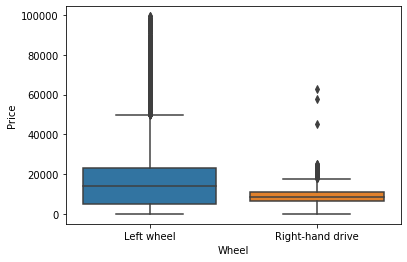

In [58]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots()
sns.boxplot(data=temp_df.loc[ids, :], x="Wheel", y="Price", ax=ax)
plt.show()

Heatmap

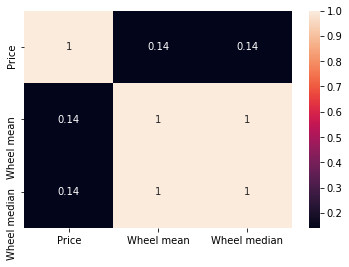

In [59]:
ids = temp_df[temp_df["Price"]<1e5].index
temp_subset = temp_df.loc[ids, :]

mean_ordering = temp_subset.groupby(by="Wheel")["Price"].mean().sort_values(ascending=True)
mean_map = {wheel: wheel_idx for wheel_idx, wheel in enumerate(mean_ordering.index)}
temp_df["Wheel mean"] = temp_df["Wheel"].map(mean_map)

median_ordering = temp_subset.groupby(by="Wheel")["Price"].median().sort_values(ascending=True)
median_map = {wheel: wheel_idx for wheel_idx, wheel in enumerate(median_ordering.index)}
temp_df["Wheel median"] = temp_df["Wheel"].map(median_map)

fig, ax = plt.subplots()
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True)
plt.show()

### Color

Collecting columns

In [60]:
temp_df = pd.DataFrame(
    np.c_[
          train_features["Color"],
          train_targets["Price"].to_numpy()
        ], 
    columns=["Color", "Price"]
  )
temp_df["Price"] = temp_df["Price"].astype(np.int)
temp_df.head()

,Color,Price
0,Grey,21953
1,Black,8154
2,Grey,8674
3,Blue,7840
4,White,53154


Boxplots

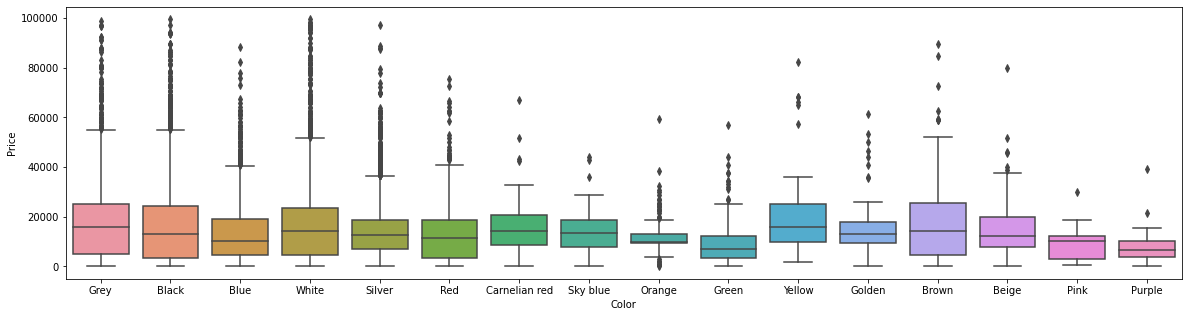

In [61]:
ids = temp_df[temp_df["Price"]<1e5].index
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=temp_df.loc[ids, :], x="Color", y="Price", ax=ax)
plt.show()

Heatmap

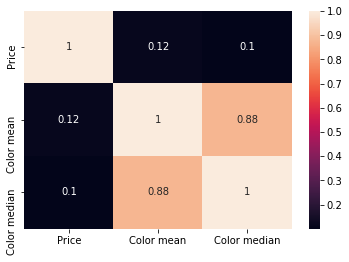

In [62]:
ids = temp_df[temp_df["Price"]<1e5].index
temp_subset = temp_df.loc[ids, :]

mean_ordering = temp_subset.groupby(by="Color")["Price"].mean().sort_values(ascending=True)
mean_map = {color: color_idx for color_idx, color in enumerate(mean_ordering.index)}
temp_df["Color mean"] = temp_df["Color"].map(mean_map)

median_ordering = temp_subset.groupby(by="Color")["Price"].median().sort_values(ascending=True)
median_map = {color: color_idx for color_idx, color in enumerate(median_ordering.index)}
temp_df["Color median"] = temp_df["Color"].map(median_map)

fig, ax = plt.subplots()
sns.heatmap(temp_df.loc[ids, :].corr(), annot=True)
plt.show()

# Notes

## Numeric Columns

- `Prod. year`: 
  - Converted this to `Time Difference`, to check effect of depreciation on Price.
  - There is no linear trend here.
  - Since, the relationship is not linear, add polynomial features and check feature importance during modeling. 
  - Clip some of the outliers (`Price > 100,000`)
  - Make a new categorical feature indicating how new a car is.
  

- `Cylinders`:
  - Clip some of the outliers (`Price > 100,000`)
  - No obvious relationship with price
  - Majority values are `4`, so maybe not very useful.

- `Airbags`
  - Clip some of the outliers (`Price > 100,000`)
  - No obvious relationship with price


**Feature Engineering:**
- From `Prod. year` make a new feature for old/new car.
- Add polynomial features for `Prod. year` (Experiment with degree)
- Make `Cylinders` and `Airbags` integers.

## Object Data Type Columns

- `Levy`
  - No linear relationship with `Price`
  - Use outlier removal for `Price` anyway

- `Manufacturer`
  - Clip `Price`
  - Ordering this feature by median `Price` or frequency did not improve correlation significantly.
  
- `Model`
  - Too many categories
  - Drop this

- `Category`
  - Clip `Price`
  - Ordering this feature by median/mean `Price` or frequency did not improve correlation significantly.

- `Leather interior`
  - Clip `Price`
  - Binary variable. Use as such

- `Fuel type`
  - Clip `Price`
  - Ordering this feature by median/mean `Price`

- `Engine volume`
  - Clip `Price`
  - Not much linear relation with price
  - Presence of `Turbo` is affecting `Price` a bit
  - Might be outliers in this feature

- `Mileage`
  - Clip `Price`
  - Not much linear relation with `Price`
  - New cars are not expensive

- `Gear box type`
  - Clip `Price`
  - Not much linear relation with `Price`

- `Drive wheels`
  - Clip `Price`
  - Not much linear relation with `Price`

- `Doors`
  - Clip `Price`
  - Not much linear relation with `Price`

- `Wheel`
  - Clip `Price`
  - Not much linear relation with `Price`

- `Color`
  - Clip `Price`
  - Not much linear relation with `Price`

**Feature Engineering:**
- Order `Manufacturer`, `Category`, `Fuel type`, `Gear box type`, `Drive wheels`, `Doors`, `Wheel`, `Color` by mean, median, common class, intuition, and one-hot-encode them and check performance/inportance of all such features.
- Convert `Leather interior` to a binary 1/0 variable
- Create `Turbo` binary variable from `Engine volume`
- Convert `Engine volume` to numeric, and deal with outliers
- Create `New cars` binary feature from `Mileage`.
- `Mileage` should be numeric.
